In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

In [4]:
HIDDEN_UNITS = 256
INPUT_UNITS = 218

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(INPUT_UNITS, 2 * HIDDEN_UNITS)
        self.hidden_active1 = nn.ReLU()
        self.hidden2 = nn.Linear(2 * HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active2 = nn.ReLU()
        self.hidden3 = nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active3 = nn.ReLU()
        self.hidden4 = nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active4 = nn.ReLU()
        self.out = nn.Linear(HIDDEN_UNITS, 1)
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden_active1(x)
        x = self.hidden2(x)
        x = self.hidden_active2(x)
        x = self.hidden3(x)
        x = self.hidden_active3(x)
        x = self.hidden4(x)
        x = self.hidden_active4(x)
        x = self.out(x)
        return x

In [6]:
model = Net()
summary(model, input_size=(1, 218))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Linear: 1-1                            [1, 512]                  112,128
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 256]                  131,328
├─ReLU: 1-4                              [1, 256]                  --
├─Linear: 1-5                            [1, 256]                  65,792
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 256]                  65,792
├─ReLU: 1-8                              [1, 256]                  --
├─Linear: 1-9                            [1, 1]                    257
Total params: 375,297
Trainable params: 375,297
Non-trainable params: 0
Total mult-adds (M): 0.38
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.50
Estimated Total Size (MB)

In [7]:
X = pd.read_csv('X_10_no_bombs.csv')
y = pd.read_csv('y_10_no_bombs.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(X.shape)
X.dropna(inplace=True)
print(X.shape)

(35405, 218)
(35405, 218)


In [9]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [11]:
X_train.shape

torch.Size([28324, 218])

In [12]:
BATCH_SIZE = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
loss_list = []
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss / len(train_loader))

In [13]:
model = Net()
for i in tqdm(range(100)):   
    train(model, train_loader, optim.Adam(model.parameters(), lr=0.01), model.loss)

100%|██████████| 100/100 [06:51<00:00,  4.12s/it]


In [14]:
loss_list

[19758.72050817072,
 5754.856622906894,
 4424.91619383939,
 4009.783616076743,
 3839.5196818745703,
 3737.808386395801,
 3768.7708074772063,
 3698.282744534667,
 3579.0514426823393,
 3661.143484593514,
 3642.336345595108,
 3508.2671441278394,
 3499.481085301522,
 3584.292244525849,
 3499.3731944340348,
 3495.8569237771476,
 3408.37505755629,
 3450.865276362503,
 3381.2474050758656,
 3383.88324763382,
 3420.0224437498346,
 3356.6895710447843,
 3315.971297356668,
 3347.091629544984,
 3357.8494363616874,
 3361.7704934837047,
 3409.2273766235626,
 3309.4368046401046,
 3349.8117654081393,
 3299.485061206344,
 3303.8249806905706,
 3305.7186788382432,
 3288.777701556548,
 3355.632531857114,
 3324.1008796778005,
 3311.843706255842,
 3292.155870631371,
 3341.829674714306,
 3299.59048730579,
 3400.0837961717866,
 3329.1106008353136,
 3349.1330714860833,
 3318.0656471682996,
 3255.4604622386646,
 3314.5015563964844,
 3326.221072745915,
 3288.893240900664,
 3285.4334219766793,
 3351.303629683587,


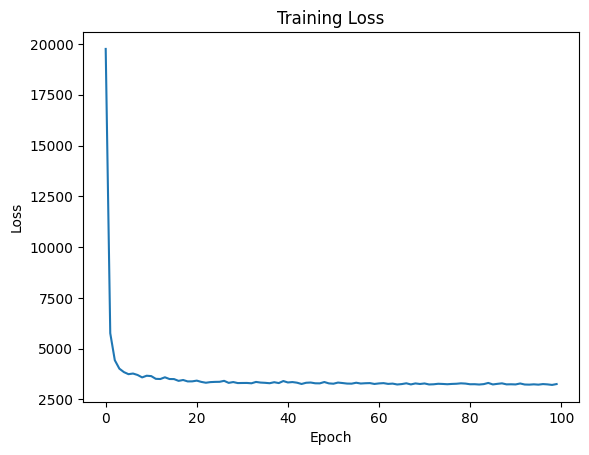

In [15]:
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
# test
model.eval()
predictions = []
for x in X_test:
    x = x.reshape(1, 218)
    x = torch.tensor(x, dtype=torch.float32)
    y_pred = model.forward(x)
    predictions.append(y_pred.item())

model.score = model.loss(torch.tensor(predictions, dtype=torch.float32), y_test.squeeze())
print(model.score.item())

C:\Users\charl\AppData\Local\Temp\ipykernel_49576\2067007474.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


3127.136962890625


In [17]:
r = np.corrcoef(predictions, y_test.squeeze())
print(r[0][1] ** 2)

0.8918932494608218


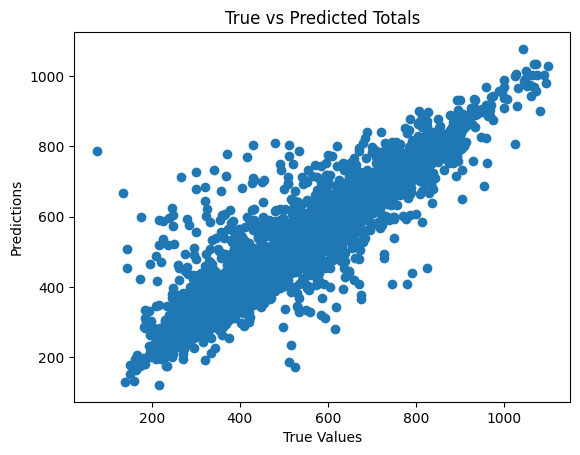

In [18]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Totals')
plt.show()